# Polymer-2, Polymer-4 and Polymer-5 classification
This notebook contains the code for exploratory data analysis, preprocessing and modelling of the task of distinguishing between 1-bit polymers that use different molecules as their bulky element.

In [6]:
# Import libraries
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pipeline import *
from models import *
plt.style.use('ggplot')

## Exploratory Data Analysis
We will start with performing some exploratory data analysis to get familiar with the data and prepare for data processing. We are given 3 numpy files corresponding to 3 different polymer types and each file containing a list of sequences/events of *(timestamp, current)* pairs where each sequence represents an event of polymer going through a nanopore. Our data has a temporal nature and hence, relative current has been recorded at each timestep.

Let's first start loading all 3 files and check the shape and structure of the data.

In [2]:
polymer2_data = np.load('data/AA66266AA.npy', allow_pickle=True)
polymer4_data = np.load('data/AA66466AA.npy', allow_pickle=True)
polymer5_data = np.load('data/AA66566AA.npy', allow_pickle=True)

In [3]:
polymer2_data.shape, polymer4_data.shape, polymer5_data.shape

((22039,), (75040,), (43074,))

In [5]:
polymer2_data[:1]

array([array([[ 0.08    , 54.637756],
              [ 0.09    , 51.002583],
              [ 0.1     , 47.99831 ],
              [ 0.11    , 45.675003],
              [ 0.12    , 44.04268 ],
              [ 0.13    , 43.08131 ],
              [ 0.14    , 42.6507  ],
              [ 0.15    , 42.660713],
              [ 0.16    , 42.96114 ],
              [ 0.17    , 43.381737],
              [ 0.18    , 43.792324],
              [ 0.19    , 44.082737],
              [ 0.2     , 44.152836],
              [ 0.21    , 43.92251 ],
              [ 0.22    , 43.41178 ],
              [ 0.23    , 42.590614],
              [ 0.24    , 41.509075],
              [ 0.25    , 40.207222],
              [ 0.26    , 38.74514 ],
              [ 0.27    , 37.1729  ],
              [ 0.28    , 35.54058 ],
              [ 0.29    , 33.898243],
              [ 0.3     , 32.285946],
              [ 0.31    , 30.71371 ],
              [ 0.32    , 29.211573],
              [ 0.33    , 27.76952 ],
            

We can see that each file is an array of numpy arrays corresponding to sequences. Since sequences can be of different length, numpy treats each array as an *object* rather than a nested matrix. In the data sample above, first column corresponds to the *timestamp* and the second column corresponds to the relative *current*.

In [8]:
# Sample sequence shape
polymer2_data[0].shape, polymer4_data[0].shape, polymer5_data[0].shape, 

((425, 2), (463, 2), (125, 2))

Let's next try to visualize some samples from our data. 

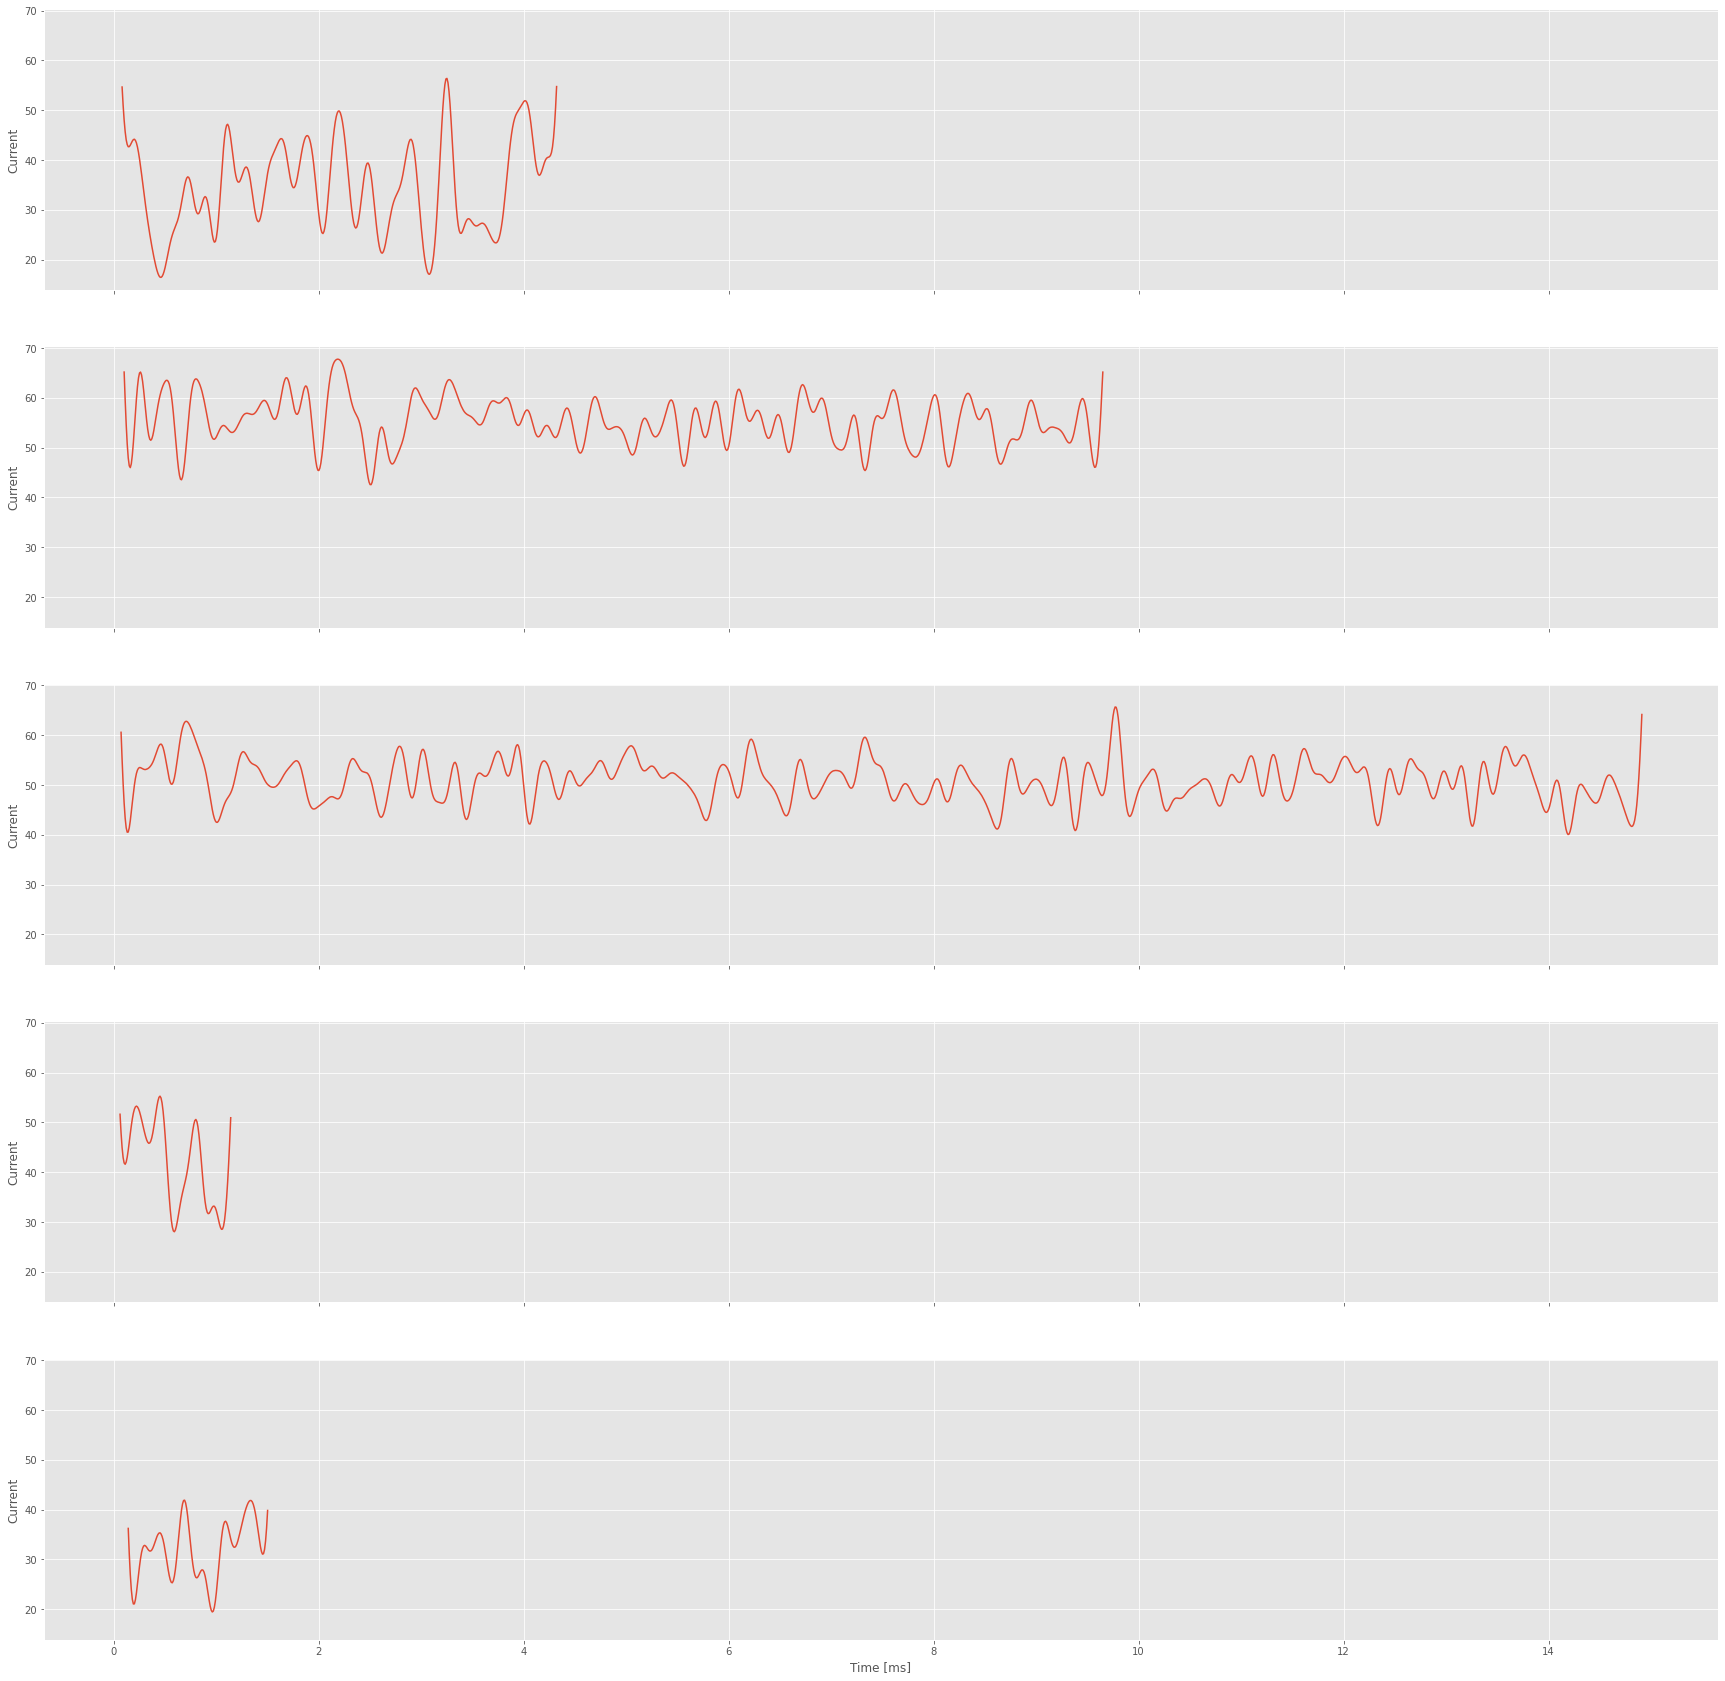

In [10]:
# Visualize data from polymer2
plot_data(polymer2_data[:5])

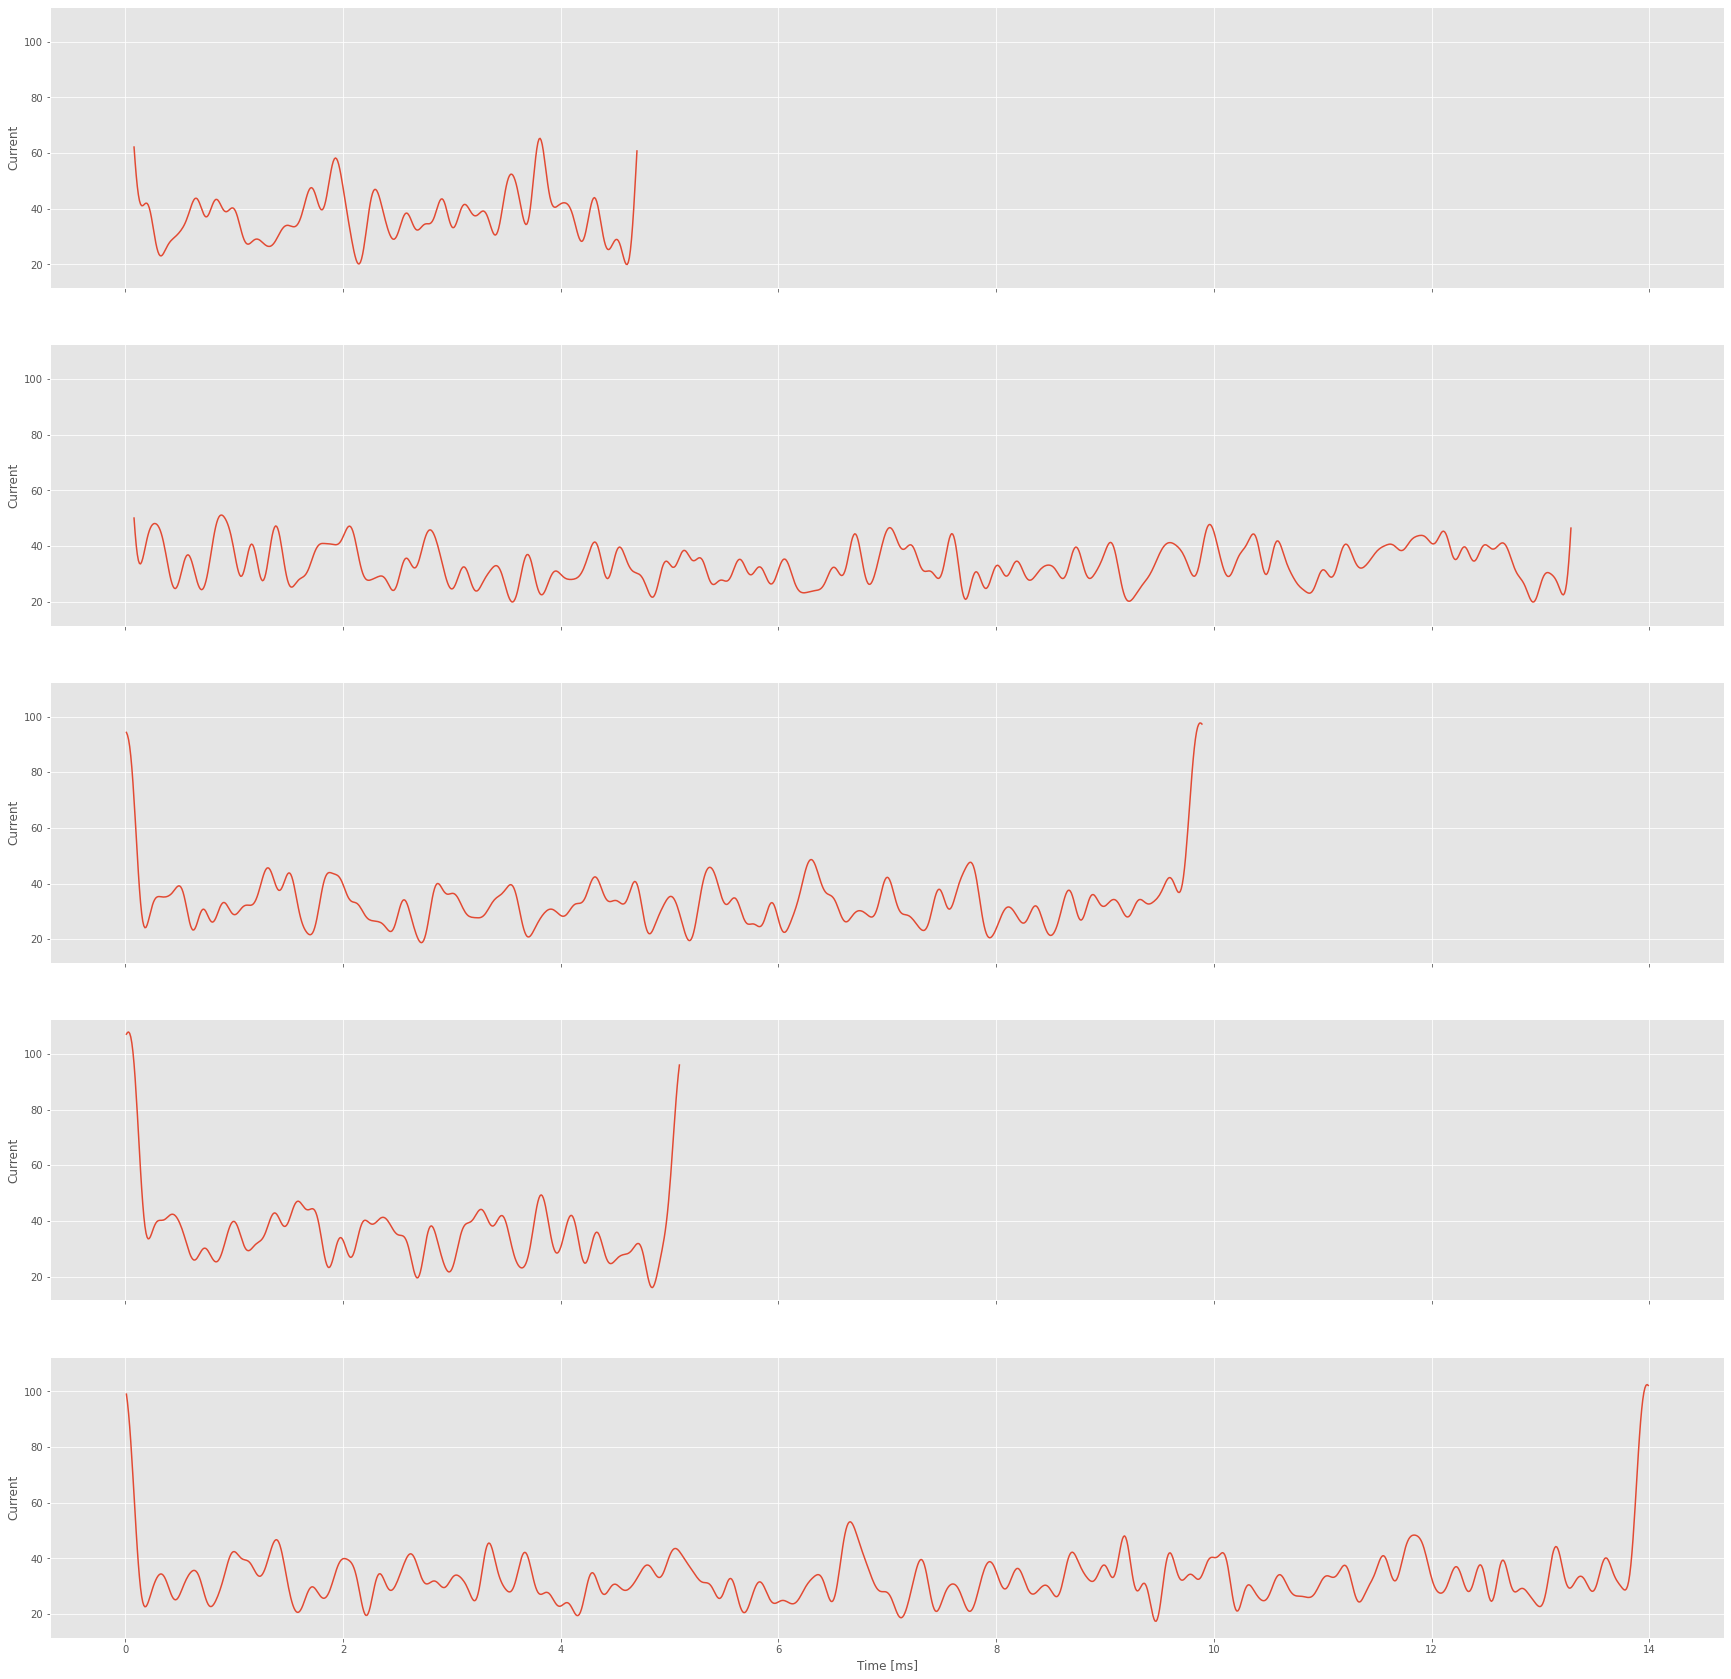

In [11]:
# Visualize data from polymer4
plot_data(polymer4_data[:5])

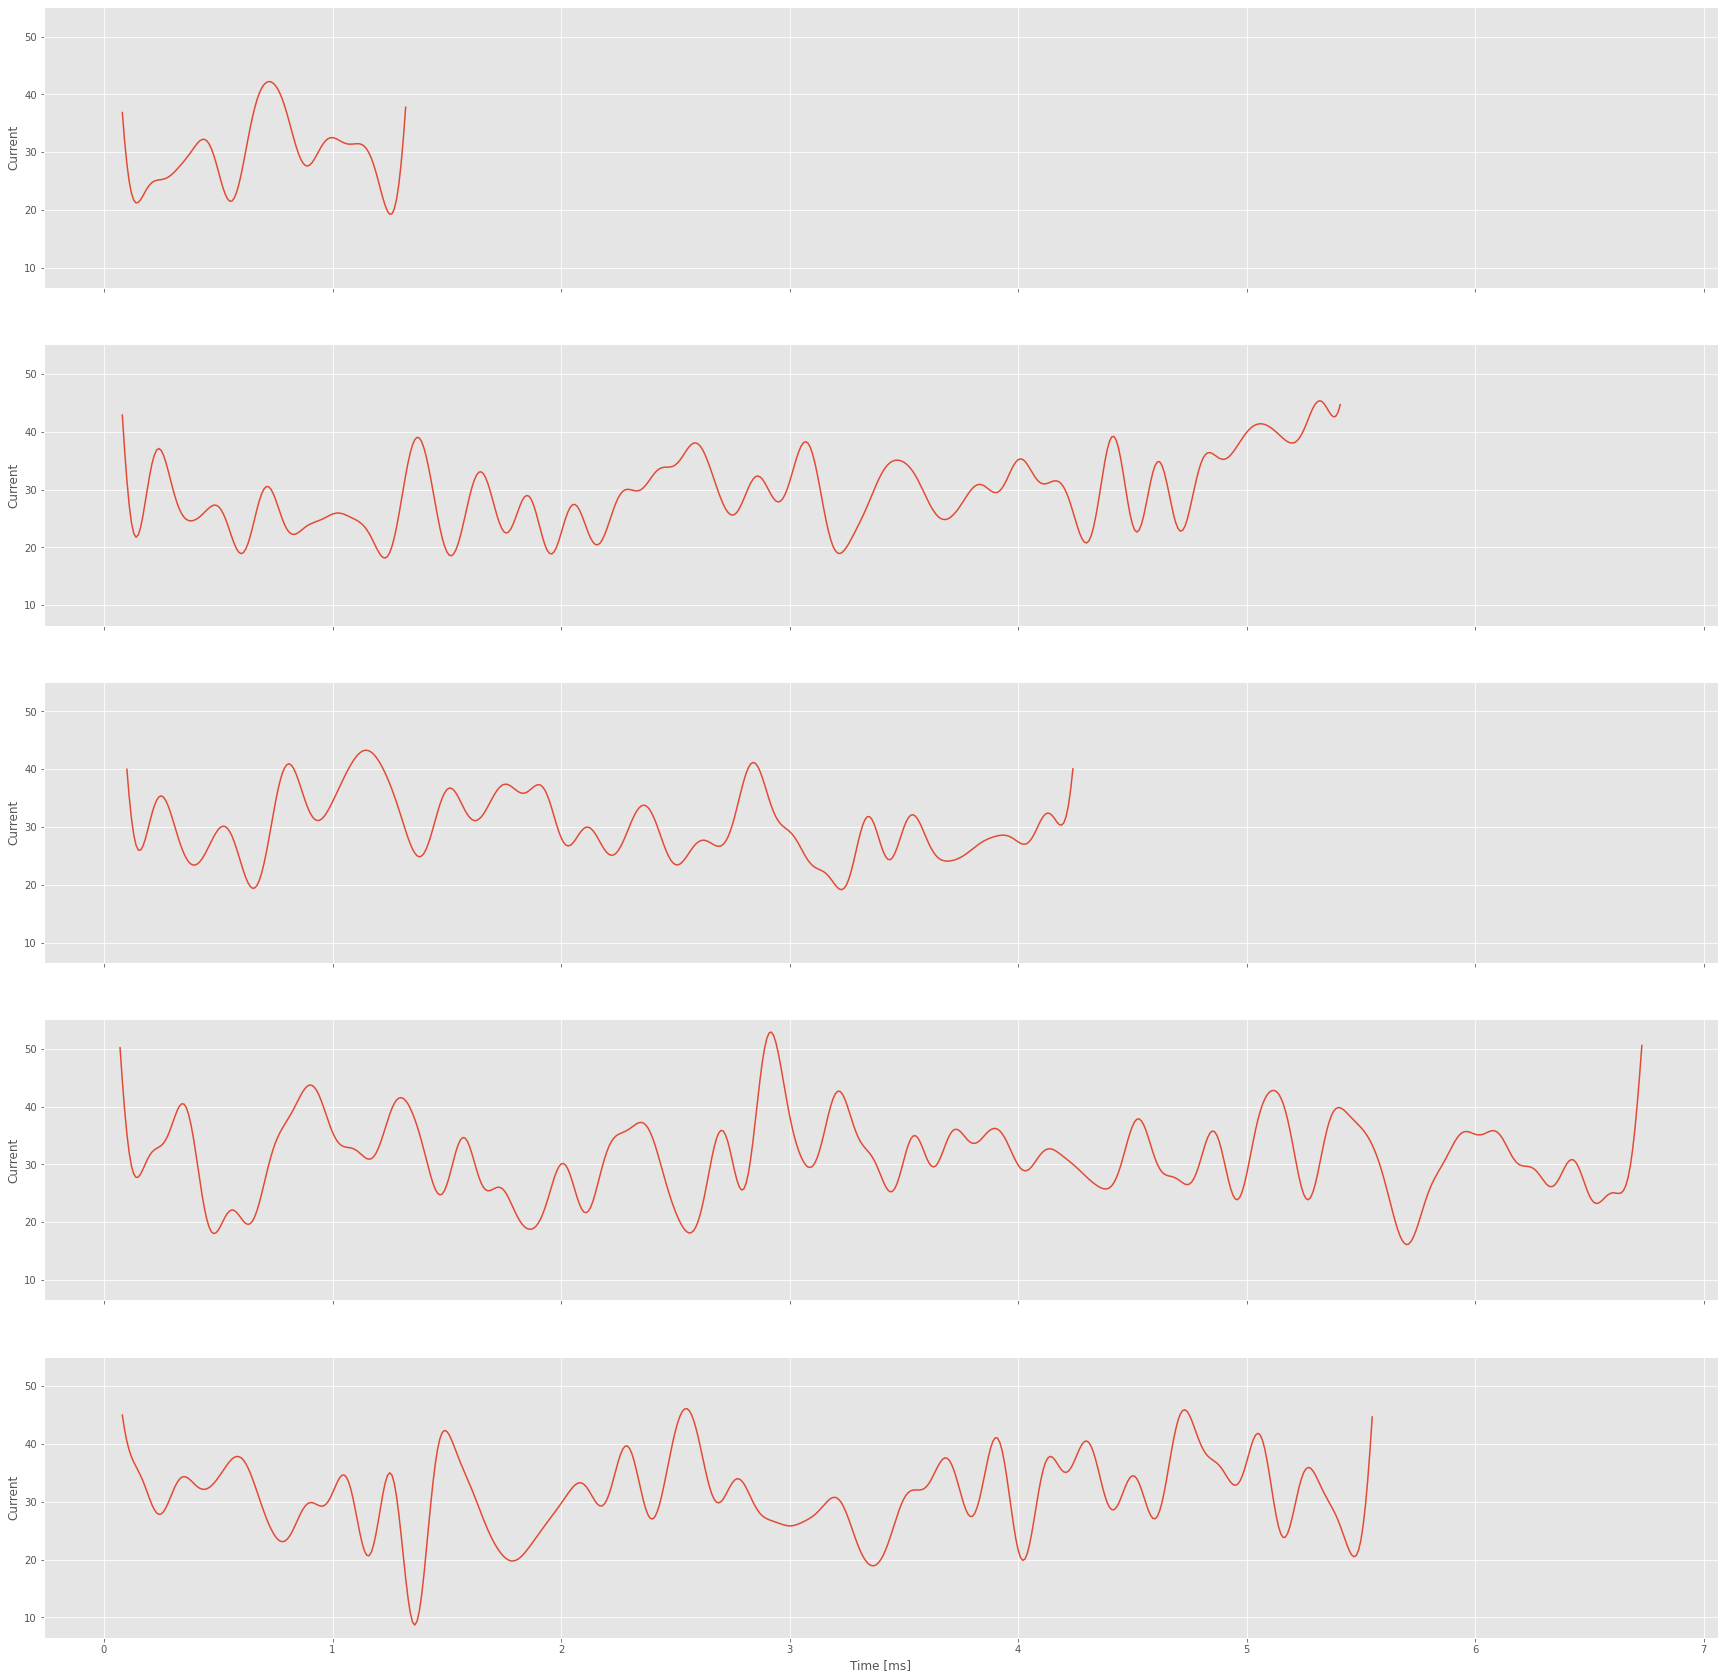

In [12]:
# Visualize data from polymer5
plot_data(polymer5_data[:5])

We can see that we have sequences of quite different lengths. Let's look at the distribution of event lengths next to understand what we are dealing with.

In [13]:
polymer2_event_lens = [len(event) for event in polymer2_data]
polymer4_event_lens = [len(event) for event in polymer4_data]
polymer5_event_lens = [len(event) for event in polymer5_data]

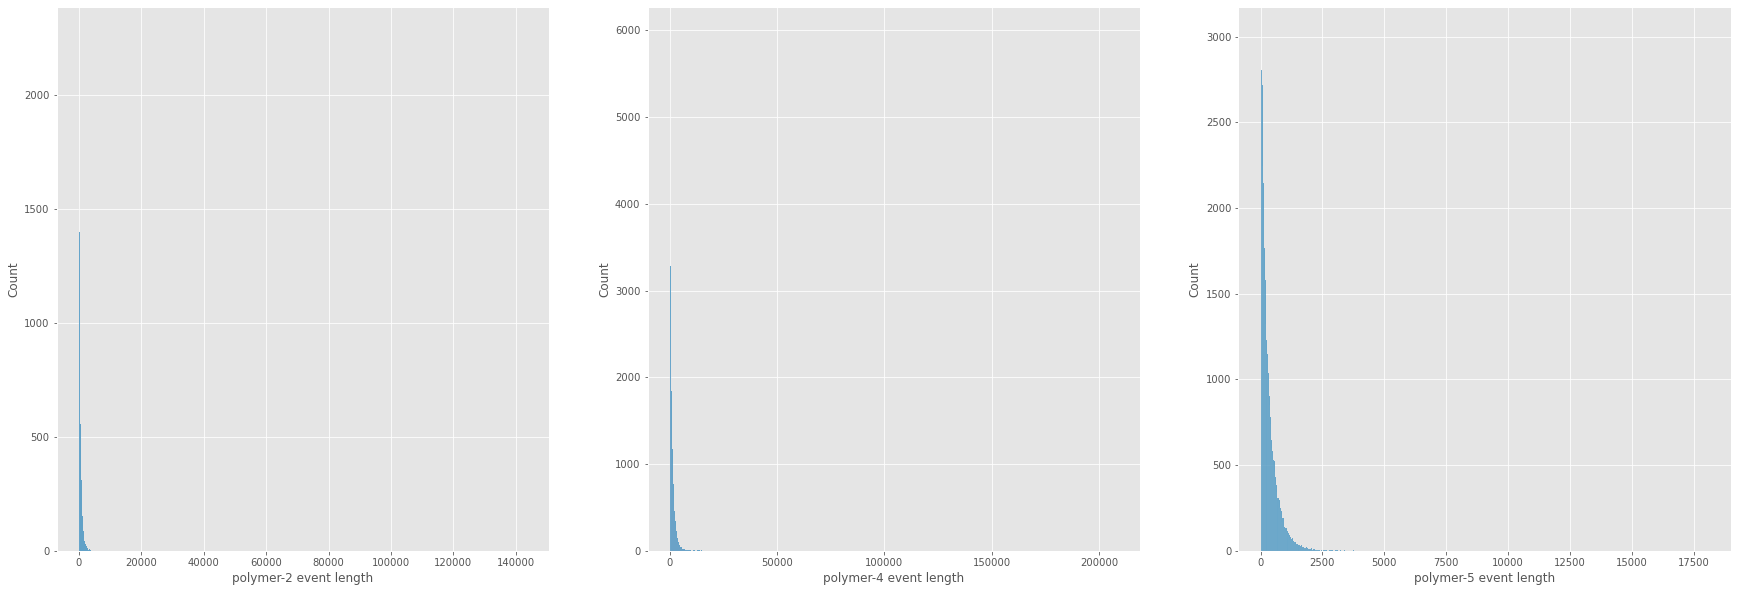

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
for ax, event_lens, ptype in zip(axes, [polymer2_event_lens, polymer4_event_lens, polymer5_event_lens], [2, 4, 5]):
    ax.set_xlabel(f'polymer-{ptype} event length')
    sns.histplot(event_lens, ax=ax)

We can see that we have very skewed distributions for all event lengths and it is a little harder to see because of the outliers. Let's apply log-scaling on the y-axis for better visualization.

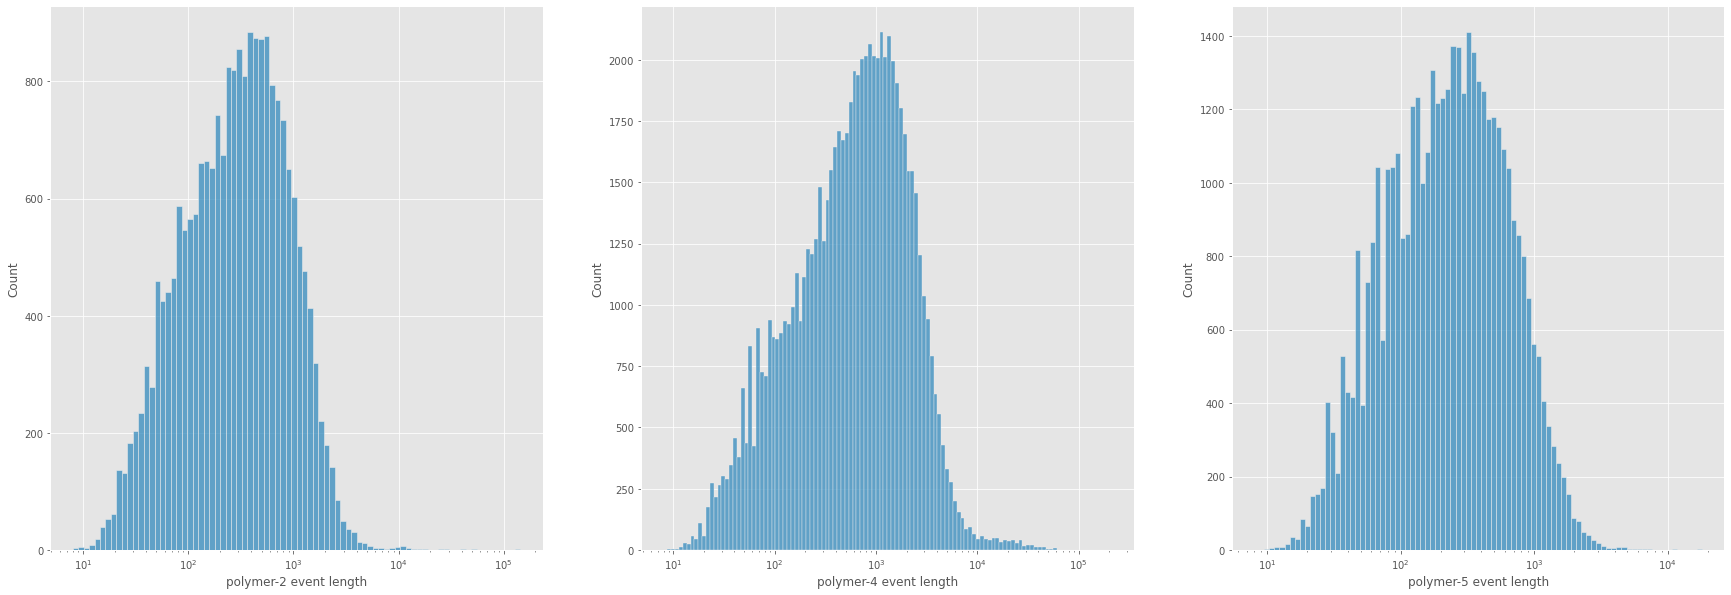

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
for ax, event_lens, ptype in zip(axes, [polymer2_event_lens, polymer4_event_lens, polymer5_event_lens], [2, 4, 5]):
    ax.set_xlabel(f'polymer-{ptype} event length')
    sns.histplot(event_lens, ax=ax, log_scale=True)

It shows that most of the polymer sequence lengths fall between the range of 10 and 10,000 and the rest are either too short or too long events. Long events usually correspond to the case where the polymer gets stuck in the nanopore and erratically moves backward and forward to escape. On the other hand, short events typically don't contain any useful information about the polymer structure.

Let's next look at the distributions for the dwell time defined as the difference between the start and end timestamps of an event.

In [24]:
polymer2_dwell_times = [event[-1][0]-event[0][0] for event in polymer2_data]
polymer4_dwell_times = [event[-1][0]-event[0][0] for event in polymer4_data]
polymer5_dwell_times = [event[-1][0]-event[0][0] for event in polymer5_data]

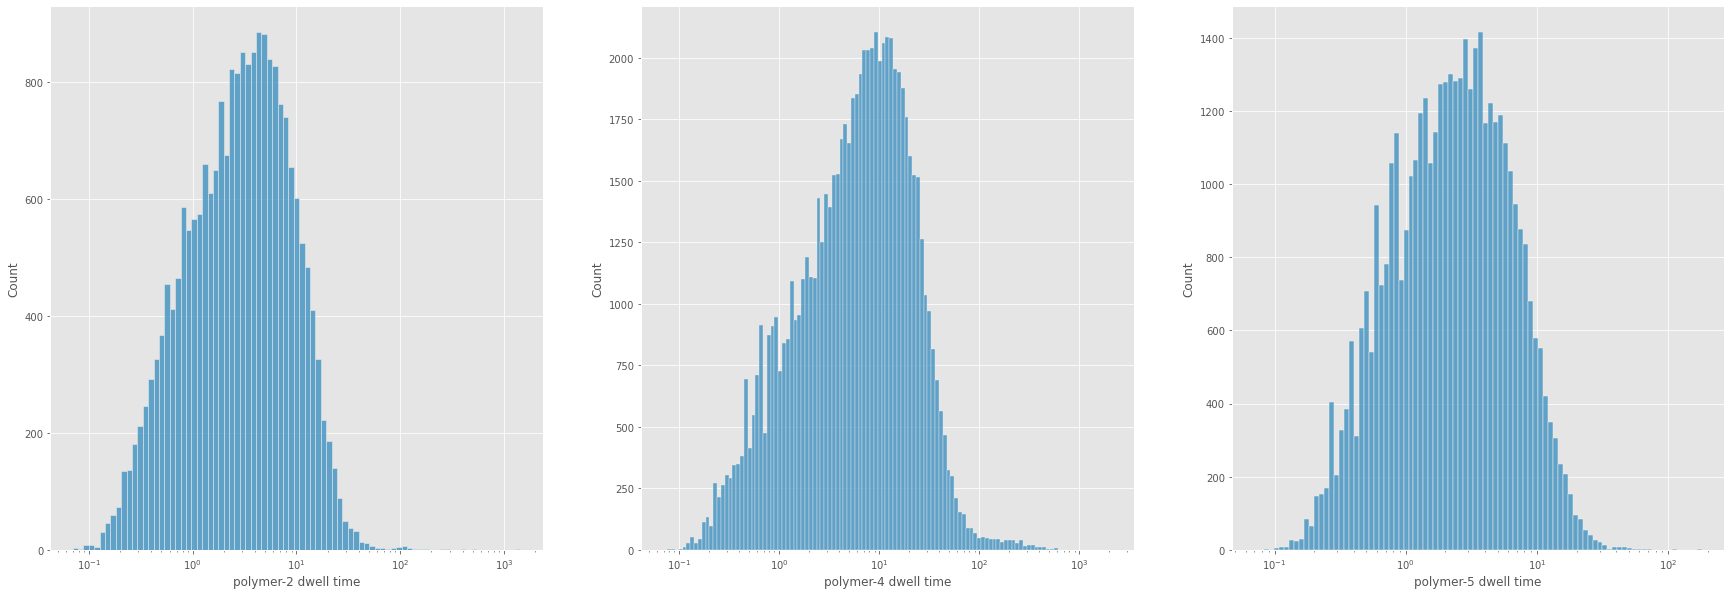

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
for ax, dwell_times, ptype in zip(axes, [polymer2_dwell_times, polymer4_dwell_times, polymer5_dwell_times], [2, 4, 5]):
    ax.set_xlabel(f'polymer-{ptype} dwell time')
    sns.histplot(dwell_times, ax=ax, log_scale=True)

We can see that it is pretty much identical to the sequence length. Next, let's check the relative current distributions. 

In [31]:
polymer2_currents = np.concatenate([event[:, 1] for event in polymer2_data])
polymer4_currents = np.concatenate([event[:, 1] for event in polymer4_data])
polymer5_currents = np.concatenate([event[:, 1] for event in polymer5_data])

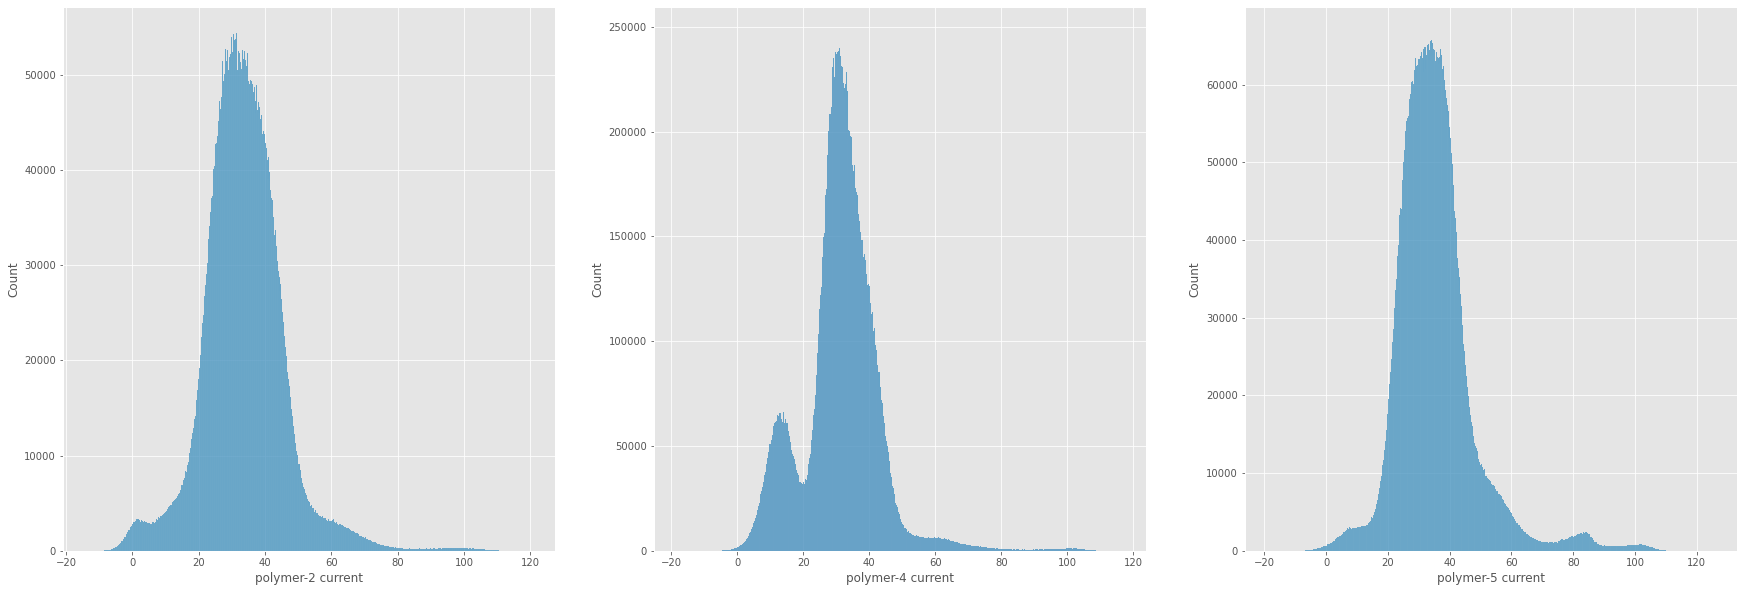

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
for ax, currents, ptype in zip(axes, [polymer2_currents, polymer4_currents, polymer5_currents], [2, 4, 5]):
    ax.set_xlabel(f'polymer-{ptype} current')
    sns.histplot(currents, ax=ax)

We can see that Polymer-2 and Polymer-5 relative current distributions looks pretty similar. This might already indicate that it could be hard to distinguish between them. Let's look at the difference between these current based on some basic statistics.

In [32]:
polymer_currents = [polymer2_currents, polymer4_currents, polymer5_currents]
polymers = [2, 4, 5]
stats = ['mean', 'median', 'std', 'min', 'max']
polymer_stats = pd.DataFrame({
    'polymer': np.concatenate([[p] * len(stats) for p in polymers]),
    'stat': stats * len(polymers),
    'value': np.concatenate([[np.mean(currents), np.median(currents), np.std(currents), np.min(currents), np.max(currents)] for currents in polymer_currents])
})

<AxesSubplot:xlabel='stat', ylabel='value'>

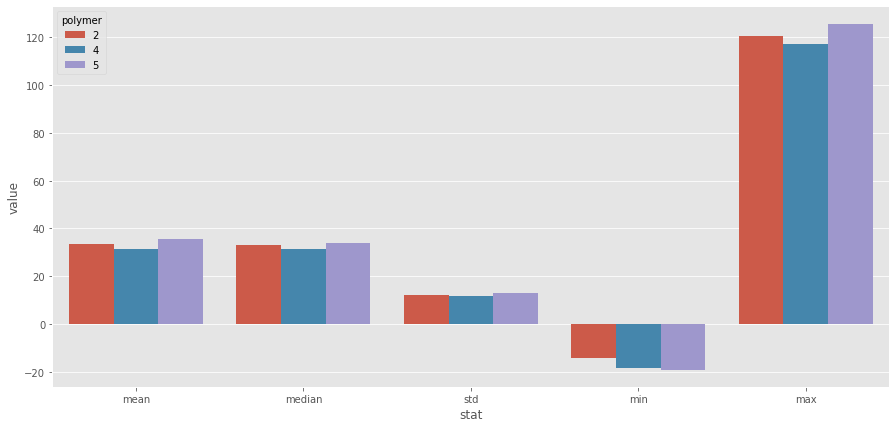

In [34]:
sns.barplot(data=polymer_stats, x='stat', y='value', hue='polymer')

## Feature Engineering
Now that we are familiar with how our data works, let's see what kind of features we can engineer to represent this data and feed into our models. 

### Basic features
First, given a sequence of some length, we will simply aggregate all current values by various basic stats like min, max, mean, median, std and also record the dwell time and the lenght of the sequence.

In [35]:
# Sample event and its basic features
event = polymer2_data[0]
basic_features = extract_basic_features(event)
basic_features

array([425.        ,   4.24000025,  56.370224  ,  16.41335869,
        34.78835297,   9.06980228,  34.82956696])

### Extrema features
Next, since our data has a signal nature to it and signals typically are characterized by their extrema points, it would be natural to apply the same technique in our case to get some more features. More specifically, we will find the extremum points of each event and apply basic statistic aggregations on them.

In [36]:
# Sample event and its extrema features
event = polymer2_data[0]
extrema_features = extract_extrema_features(event)
extrema_features

array([14.        , 15.        , 21.96368217, 20.70732117, 14.7695179 ,
       13.63574791])

Let's visualize how we are capturing these extrema. We use a parameter called *extrema_th* to control what constitutes as an extremum. It sets the lower bound on the difference between 2 nearby extrema. By default, this parameter equals to 0 and we consider any point in the event that is a local extremum. 

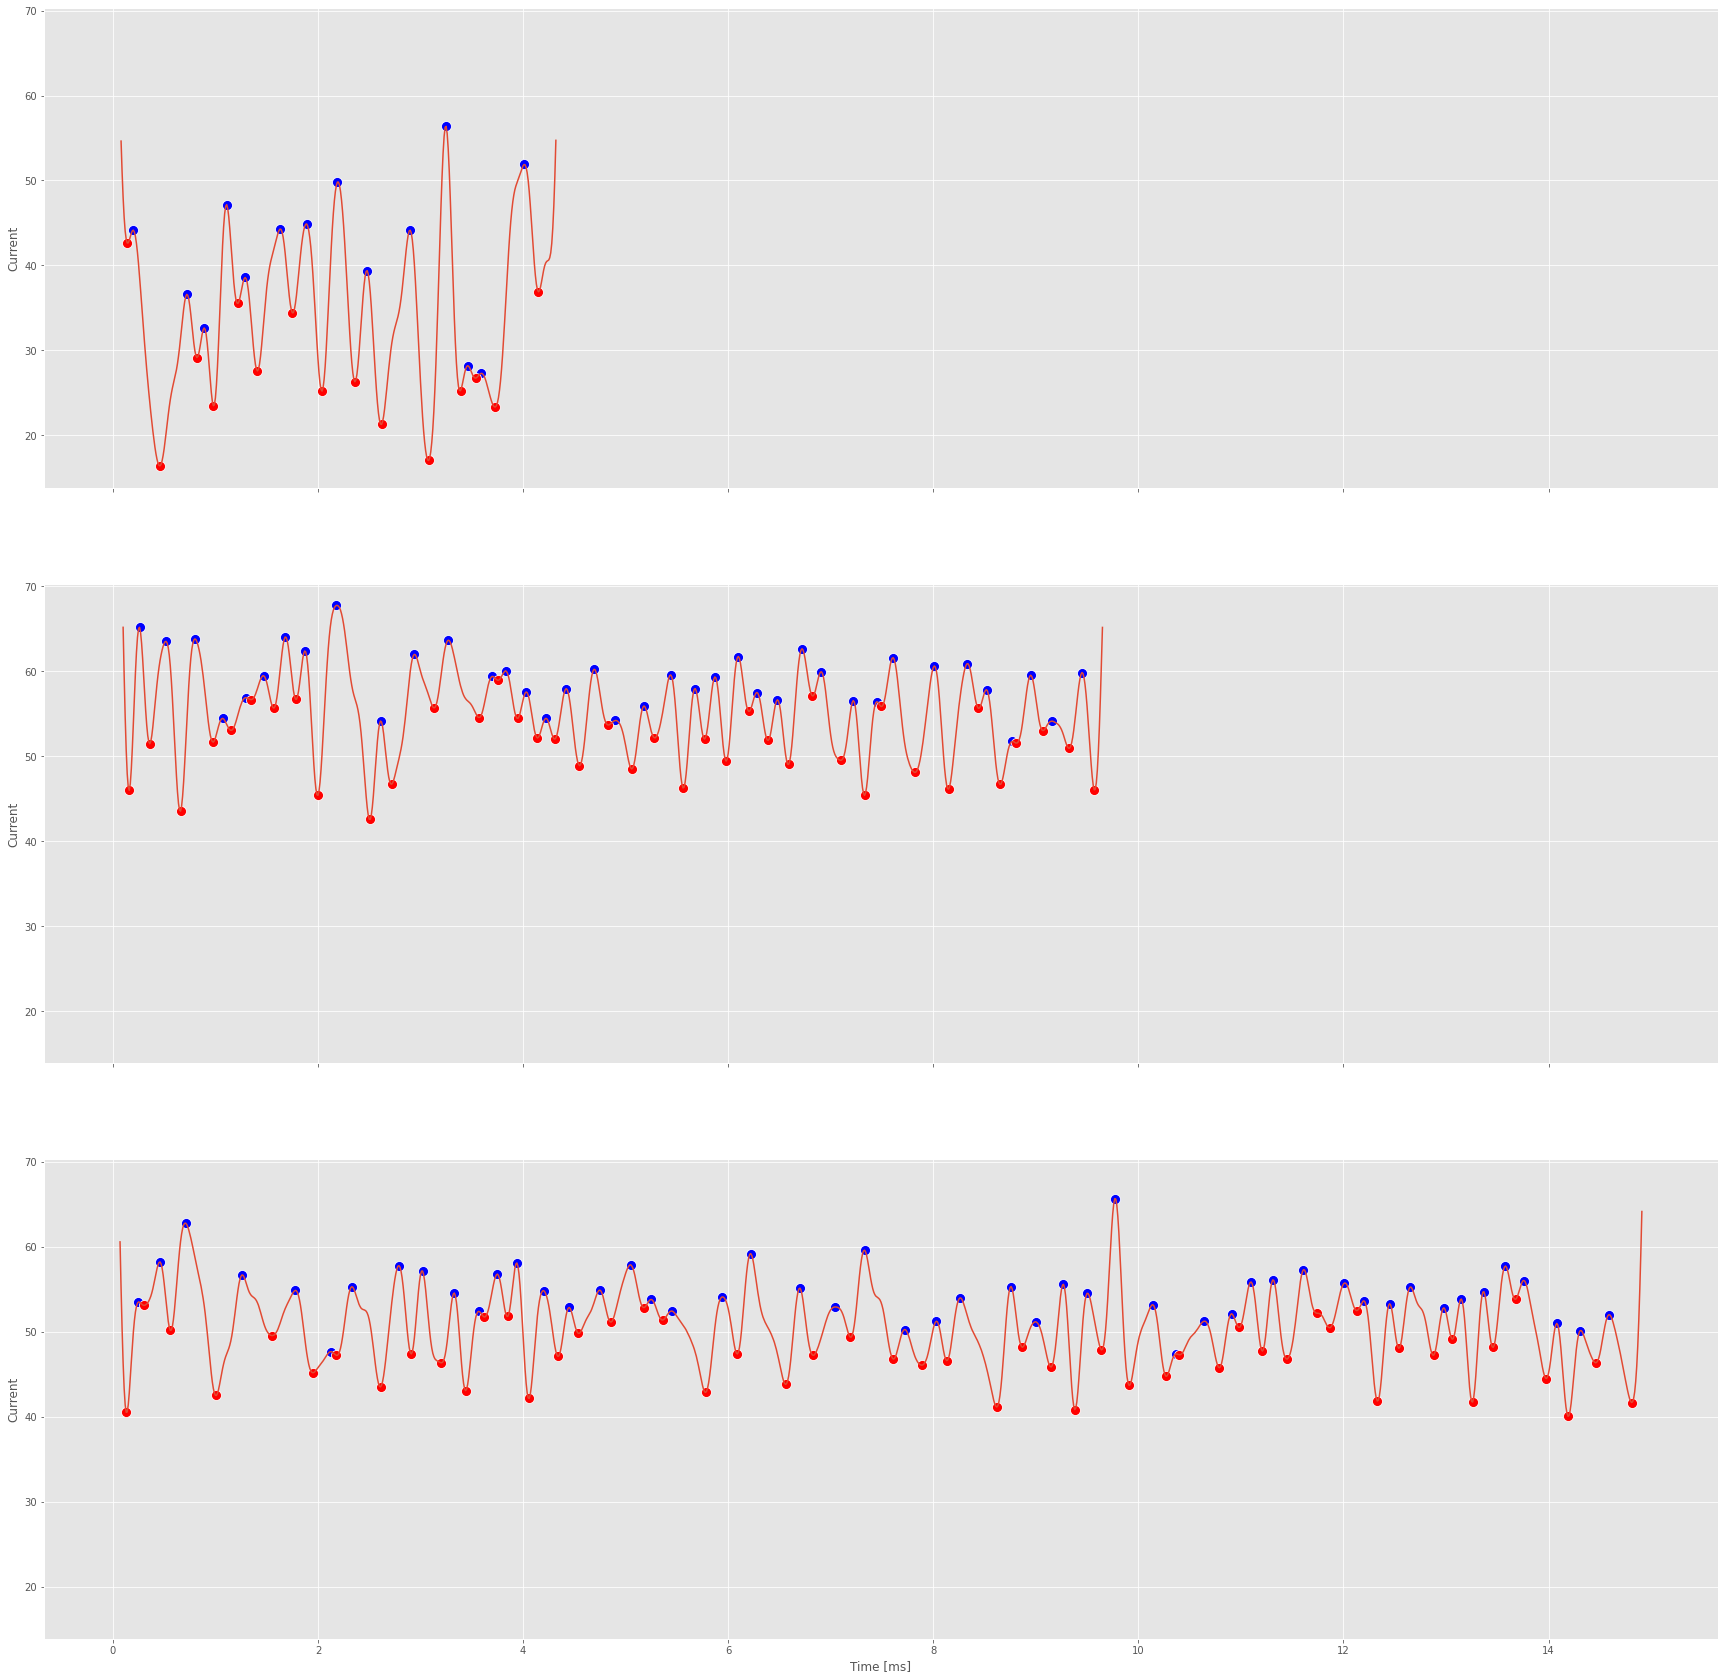

In [37]:
plot_data(polymer2_data[:3], plot_extrema=True, extrema_th=0)

However, some points are extremely local extrema and may not be a representative of the event. So, we can increase the *extrema_th* to prune out these points.

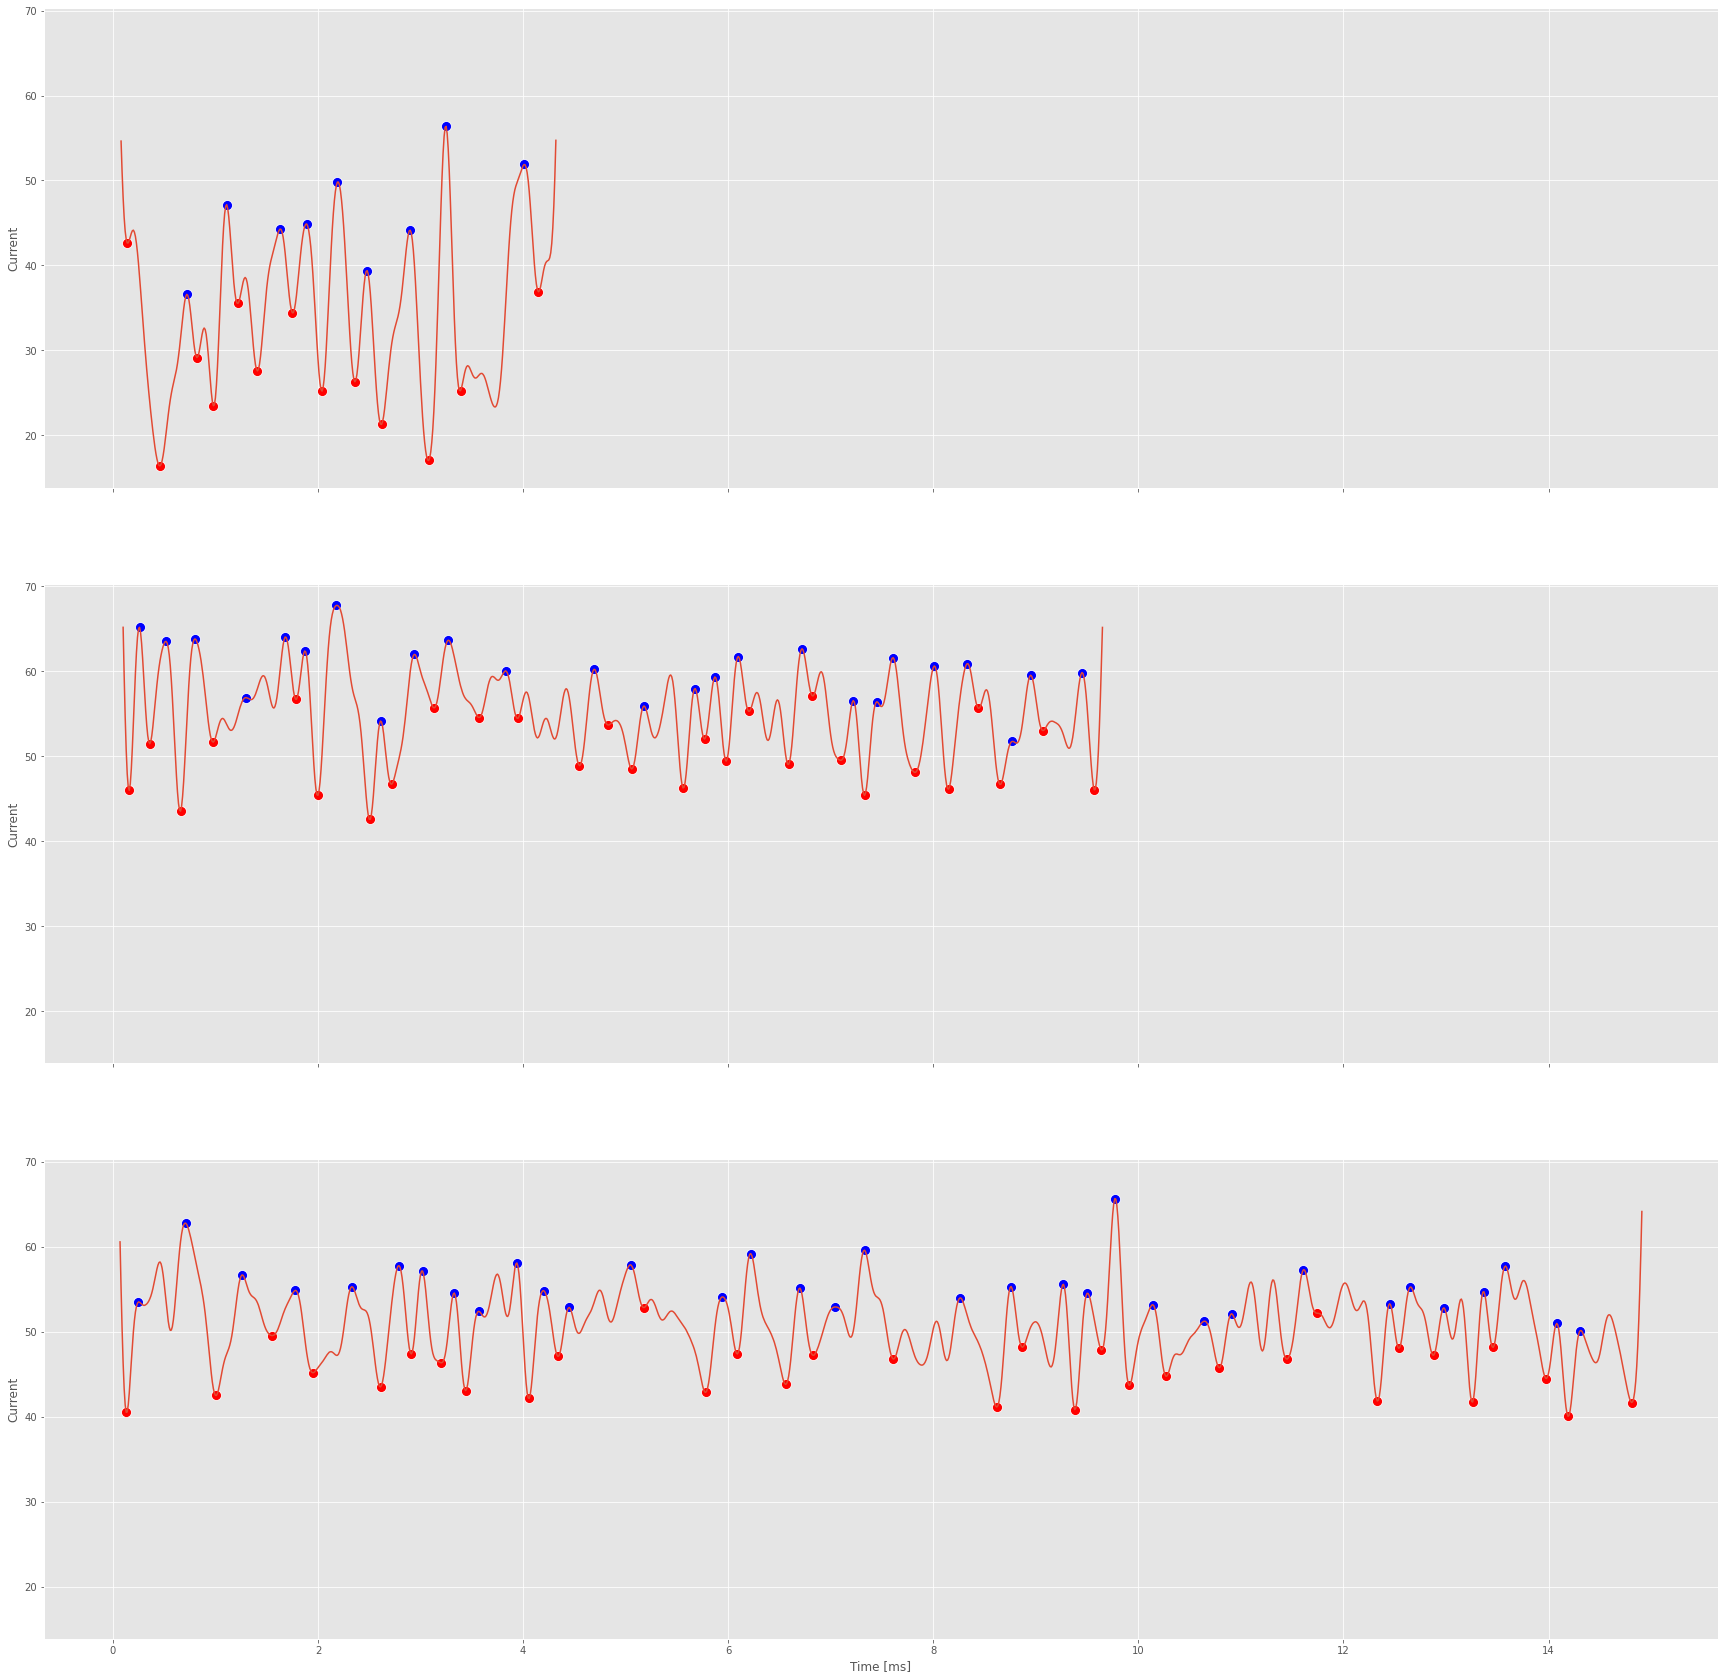

In [38]:
plot_data(polymer2_data[:3], plot_extrema=True, extrema_th=5)

As you can see, this setting seems to capture the representation of the data better. Of course, it is hard to know in advance what value of *extrema_th* will work better, so we will treat this as a hyperparameter later on in our modelling stage.

### FFT features
Finally, again since our data has a temporal structure and is signal based, it would be natural to apply FFT transformation to reduce the complexity of the signal and hopefully, come up with characteristic features. We will essentially apply an FFT transformation to the relative currents of a given event, take the absolute value of the results also known as FFT amplitudes and apply again basic aggregation functions to produce new features.

In [39]:
# Sample event and its FFT features
event = polymer2_data[0]
fft_features = extract_fft_features(event)
fft_features

array([1.47850512e+04, 1.54329532e-01, 9.30219105e+01, 7.35292869e+02,
       3.65000010e+00])

Let's visualize what these features might capture in our data.

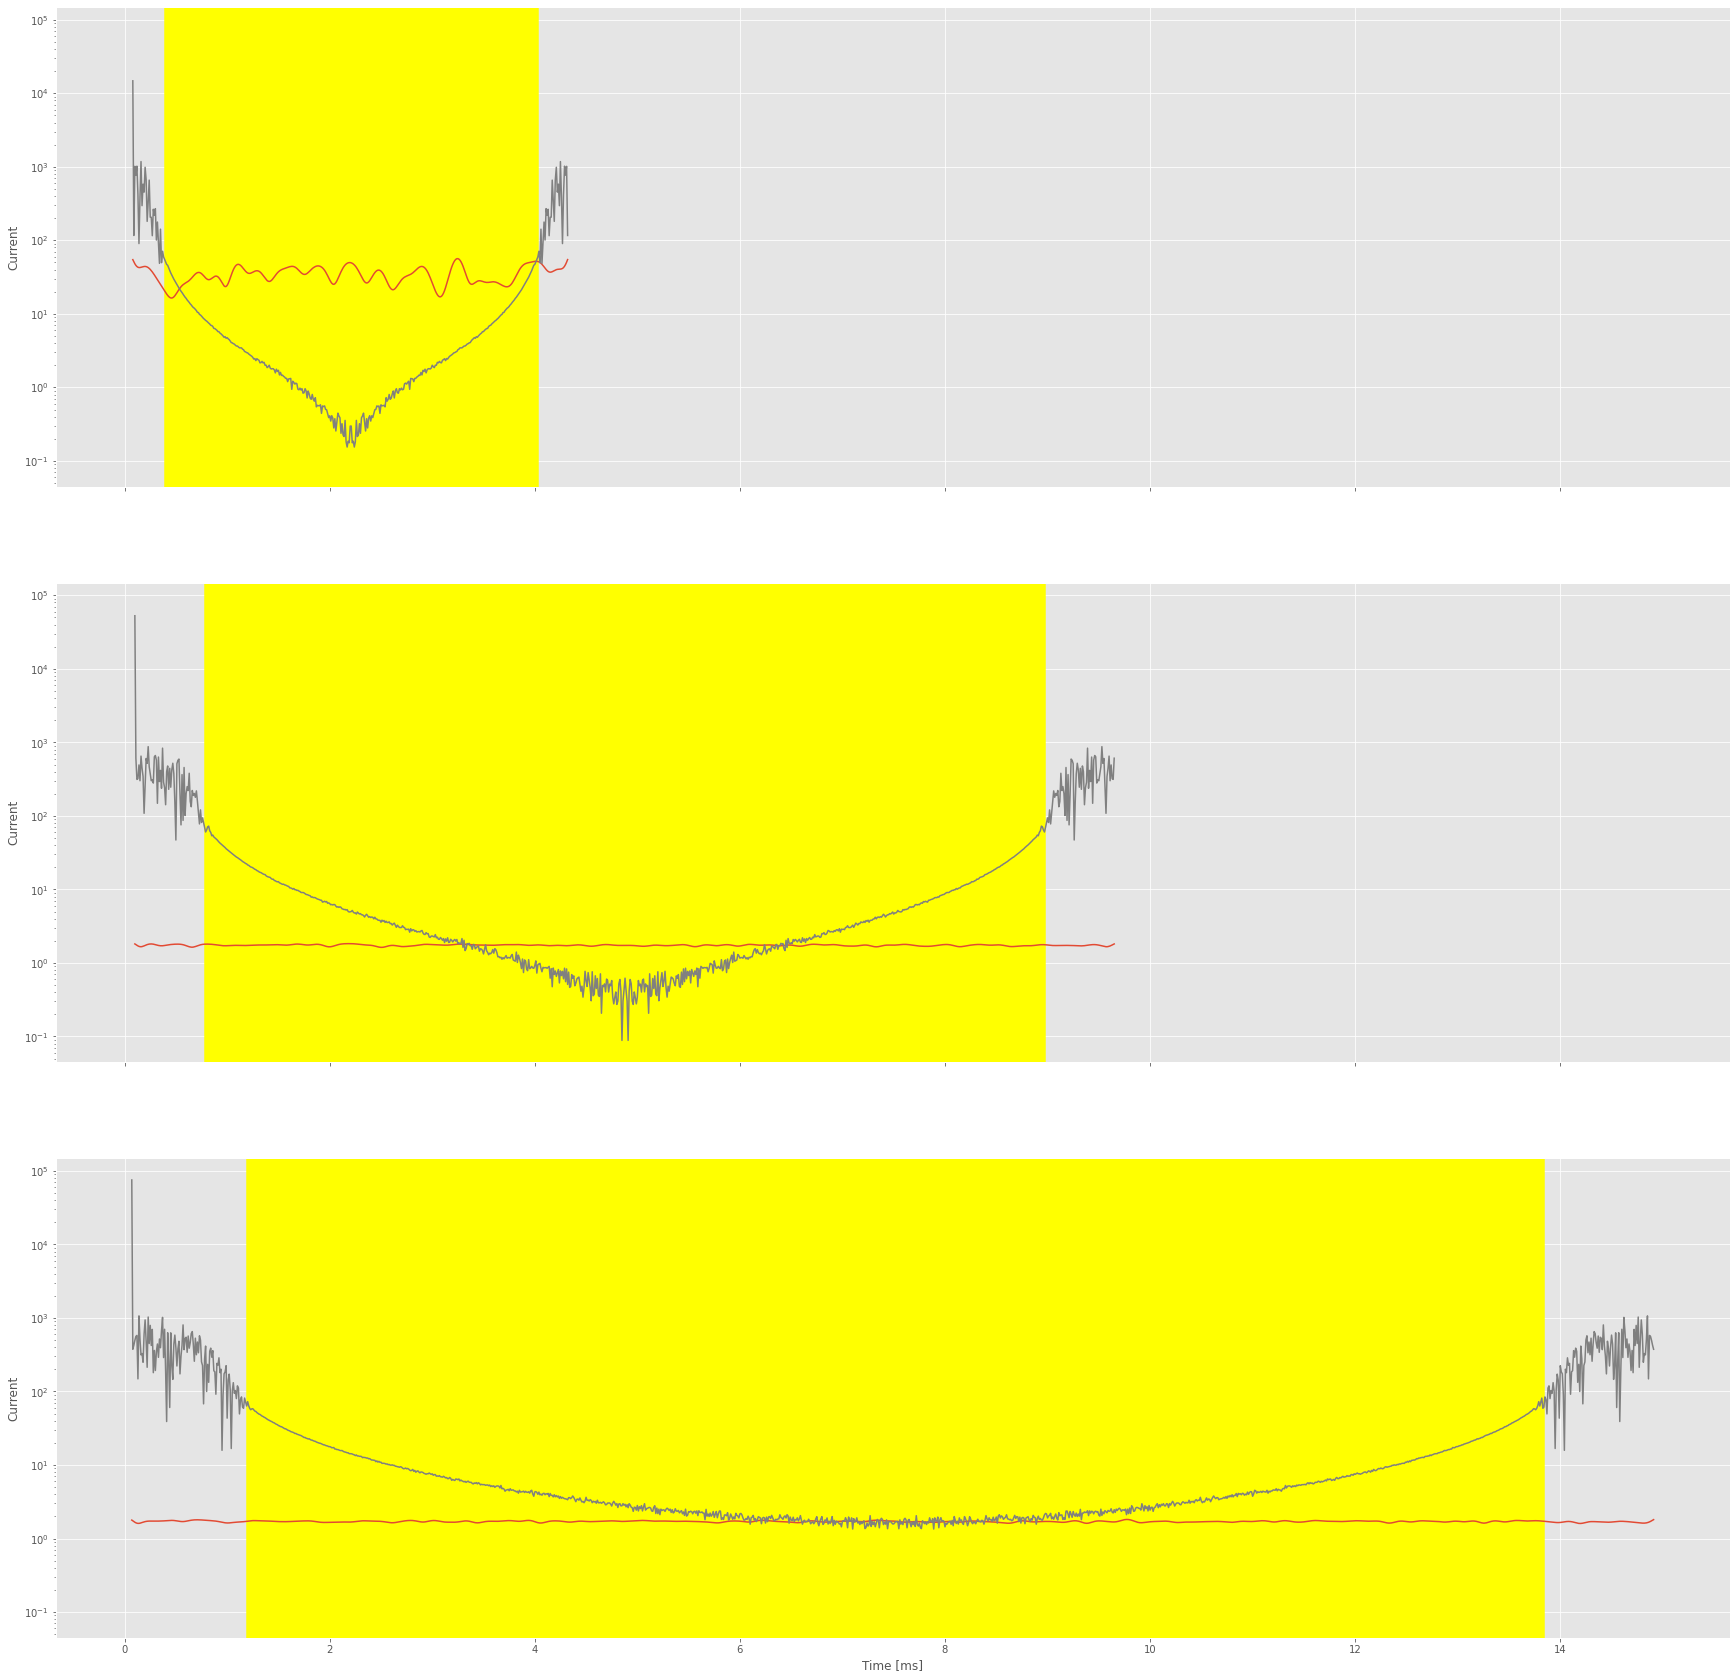

In [41]:
plot_data(polymer2_data[:3], plot_fft=True)

Here, the red plot is the original signal and the grey plot is its FFT transformation while the yellow region is the region of low-activity in the signal.

## Data Preprocessing
We now know how to represent our time-series data, let's look at what further processing we need to do before we feed our data into a model. First of all, since each sequence in our dataset has a different length, we will split each event into fixed number of blocks specified either by the parameter *num_blocks* or *block_size*. In order to make our preprocessing streamlined across different tasks, we created a class called *Pipeline* with basic preprocessing methods that can be further overriden to adapt to the task at hand. This class takes at a minimum the number of blocks needed to split the data into.

In [50]:
pipeline = AABB245_Pipeline(num_blocks=8)

### Balancing
First, we notice that our data is quite imbalanced as we have data for polymer-5 which is approximately twice the number of samples we have for polymer-4 which in turn is more than around twice the data points we have for polymer-2. If we simply take all the data as it is and if we use accuracy as a metric, then the results would be deceiving as we know accuracy is a poor metric for imbalanced data and in general, imbalanced data is results in a not-so-robust classification model. Therefore, our pipeline will first make the its data balanced.

In [51]:
data = pipeline.load(['data/AA66266AA.npy', 'data/AA66466AA.npy'])
data = pipeline.balance(data)

In [52]:
data[0].shape, data[1].shape

((22039,), (22039,))

### Filtering
Next we would like to filter out some outlier events from our data such as too short and too long events as we discussed above wouldn't be good representative our data. Here, we can either prune the events outside certain quantile range of our data or hard-code the minimum and maximum thresholds. Parameters for these settings can be tuned in the modelling stage.

In [53]:
data = pipeline.filter(data)

In [54]:
data[0].shape, data[1].shape

((20085,), (20775,))

### Processing
Next we process our data to extract features as we discussed above.

In [55]:
data, labels = pipeline.process(data)

Processing data/AA66466AA.npy: 100%|██████████| 20775/20775 [02:29<00:00, 138.59it/s]


In [57]:
data.shape, labels.shape

((40860, 8, 20), (40860,))

We can see that now all our data is consolidated and is 3-dimensional where the first dimension is the number of samples, the second dimension is the number of blocks and the last dimension is the number of features.

### Standardization
Last, but not least, we standardize our data.

In [58]:
data = pipeline.standardize(data)

## Modelling
Finally, we are ready to perform some classification modelling on our data. We have put all these data processing steps into a class called *PolymerDataset* which we will use to represent our data and pass around as one object. We will train one traditional ML model *Random Forest Classifier* that does not take into account the temporal structure of the data and 2 variations of *LSTM* recurrent neural networks followed by MLP. All models will be hyperparameter-tuned using Grid Search and Cross-Validation based on the accuracy metric.

In [1]:
# Let's define a common transform function which saves and loads data from a path to avoid cost of duplicate processing
import os

def transform_data(data_paths, num_blocks=8, extrema_th=4, by_quantile=False, *args, **kwargs):
    dataset_path = f"data/AA245_b{num_blocks}_e{extrema_th}_q{by_quantile}"
    pipeline = AABB245_Pipeline(num_blocks=num_blocks, extrema_th=extrema_th, by_quantile=by_quantile)
    if os.path.exists(f'{dataset_path}_data.pt'):
        dataset = PolymerDataset(data_paths, pipeline, load_path=dataset_path)
    else:
        dataset = PolymerDataset(data_paths, pipeline, save_path=dataset_path)
    return dataset

### Random Forest Classifier

#### Hyperparameter tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def build_model(n_estimators=100, min_samples_split=2, min_samples_leaf=2, *args, **kwargs):
    return RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, random_state=42)

def train_rf(dataset, model, *args, **kwargs):
    data_loader = DataLoader(dataset, batch_size=len(dataset))
    X, y = next(iter(data_loader))
    X, y = X.numpy(), y.numpy()
    X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
    model.fit(X, y)
    return model

def test_rf(dataset, model, *args, **kwargs):
    data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    X, y = next(iter(data_loader))
    X, y = X.numpy(), y.numpy()
    X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
    preds = model.predict(X)
    return {
        'accuracy': accuracy_score(y, preds),
        'f1_score': f1_score(y, preds, average='weighted'),
        'precision': precision_score(y, preds, average='weighted'),
        'recall': recall_score(y, preds, average='weighted'),
        'confusion_matrix': confusion_matrix(y, preds, normalize='true').round(3)
    }

data_paths = ['data/AA66266AA.npy', 'data/AA66466AA.npy', 'data/AA66566AA.npy']
param_grid = {
    'num_blocks': [3, 6, 16, 64],
    'extrema_th': [0, 10],
    'by_quantile': [False, True],
    'n_estimators': [100, 200],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 4]
}
rf_params, rf_metrics = grid_search_cv(data_paths=data_paths, param_grid=param_grid,
                                 model_fn=build_model, train_fn=train_rf, test_fn=test_rf, transform_fn=transform_data, k_fold=4)

rf_params, rf_metrics

#### Final model

### Vanilla LSTM
In this version of the LSTM, we only use the last output of the LSTM network.

#### Hyperparameter tuning

In [4]:
def build_model(dataset, *args, **kwargs):
    return VanillaLSTM(input_dim=dataset.num_features, output_dim=dataset.num_classes)

data_paths = ['data/AA66266AA.npy', 'data/AA66466AA.npy', 'data/AA66566AA.npy']
param_grid = {
    'num_blocks': [3, 6, 16, 64],
    'extrema_th': [0, 10],
    'by_quantile': [False, True],
    'lr_rate': [0.001, 0.01],
    'verbose': 0,
    'log': False
}

vanilla_params, vanilla_metrics = grid_search_cv(data_paths=data_paths, param_grid=param_grid,
                                 model_fn=build_model, train_fn=train, test_fn=test,
                                 transform_fn=transform_data, k_fold=4)

vanilla_params, vanilla_metrics

({'num_blocks': 16,
  'extrema_th': 0,
  'by_quantile': True,
  'lr_rate': 0.001,
  'verbose': 0,
  'log': False},
 {'accuracy': 0.7346115990308903,
  'f1_score': 0.7347471768320567,
  'precision': 0.7359197457175484,
  'recall': 0.7346115990308903,
  'confusion_matrix': [[0.7135, 0.07175000000000001, 0.21425],
   [0.07175, 0.81775, 0.11099999999999999],
   [0.22674999999999998, 0.10075, 0.6725]]})

#### Final model

In [8]:
data_paths = ['data/AA66266AA.npy', 'data/AA66466AA.npy', 'data/AA66566AA.npy']
pipeline = AABB245_Pipeline(num_blocks=vanilla_params['num_blocks'], extrema_th=vanilla_params['extrema_th'],
                            by_quantile=vanilla_params['by_quantile'])
dataset = PolymerDataset(data_paths, pipeline)
model = VanillaLSTM(input_dim=dataset.num_features, output_dim=dataset.num_classes)
train_dataset, test_dataset = train_test_split(dataset)
vanilla_model, vanilla_metrics = train(train_dataset, model, test_dataset, num_epochs=200, lr_rate=vanilla_params['lr_rate'], verbose=1, log=False)

Processing data/AA66566AA.npy: 100%|██████████| 17625/17625 [01:48<00:00, 162.24it/s]


epoch=0/200, loss=0.942289, accuracy=50.0923
epoch=0/200, test_accuracy=58.1488
epoch=50/200, loss=0.586713, accuracy=73.4953
epoch=50/200, test_accuracy=72.4210
epoch=100/200, loss=0.571661, accuracy=74.1767
epoch=100/200, test_accuracy=72.5535
epoch=150/200, loss=0.567374, accuracy=74.5245
epoch=150/200, test_accuracy=72.5535
epoch=199/200, loss=0.553058, accuracy=75.3620
epoch=199/200, test_accuracy=72.0140


In [9]:
vanilla_metrics

{'accuracy': 0.7201400719288283,
 'f1_score': 0.7186816874526908,
 'precision': 0.7268377078016174,
 'recall': 0.7201400719288283,
 'confusion_matrix': array([[0.59 , 0.089, 0.321],
        [0.048, 0.834, 0.118],
        [0.149, 0.115, 0.736]])}

In [ ]:
torch.save(vanilla_model.state_dict(), 'vanilla_model.pth')

Let's visualize the confusion matrix.

<AxesSubplot:>

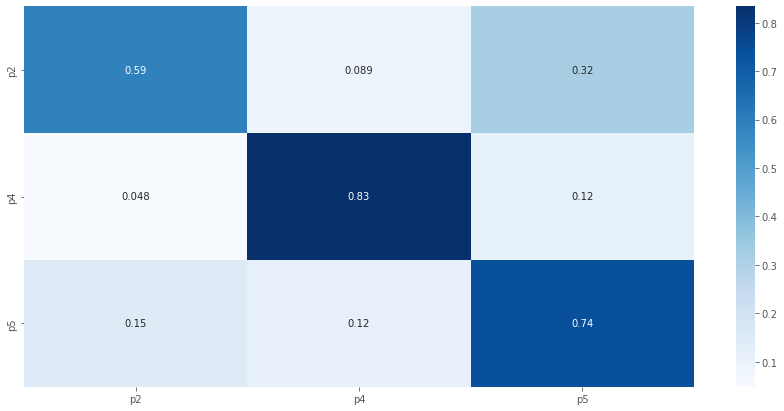

In [11]:
sns.heatmap(vanilla_metrics['confusion_matrix'], annot=True, fmt='.2', xticklabels=["p2", "p4", "p5"], yticklabels=["p2", "p4", "p5"], cmap='Blues')

### MultiOutput LSTM
In this version of LSTM, we feed all outputs of the LSTM network into the MLP network that follows it.

In [12]:
def build_model(dataset, *args, **kwargs):
    return MultiOutputLSTM(input_dim=dataset.num_features, output_dim=dataset.num_classes, num_blocks=dataset.num_blocks)

data_paths = ['data/AA66266AA.npy', 'data/AA66466AA.npy', 'data/AA66566AA.npy']
param_grid = {
    'num_blocks': [3, 6, 16, 64],
    'extrema_th': [0, 10],
    'by_quantile': [False, True],
    'lr_rate': [0.001, 0.01],
    'verbose': 0,
    'log': False
}

multi_params, multi_metrics = grid_search_cv(data_paths=data_paths, param_grid=param_grid,
                                             model_fn=build_model, train_fn=train, test_fn=test,
                                             transform_fn=transform_data, k_fold=4)

multi_params, multi_metrics

({'num_blocks': 16,
  'extrema_th': 10,
  'by_quantile': False,
  'lr_rate': 0.01,
  'verbose': 0,
  'log': False},
 {'accuracy': 0.6447273324572931,
  'f1_score': 0.6438296762717035,
  'precision': 0.6454882491371858,
  'recall': 0.6447273324572931,
  'confusion_matrix': [[0.6375000000000001, 0.09875, 0.26325],
   [0.07225, 0.7562500000000001, 0.17200000000000001],
   [0.30675, 0.157, 0.536]]})

#### Final model

In [13]:
data_paths = ['data/AA66266AA.npy', 'data/AA66466AA.npy', 'data/AA66566AA.npy']
pipeline = AABB245_Pipeline(num_blocks=multi_params['num_blocks'], extrema_th=multi_params['extrema_th'],
                            by_quantile=multi_params['by_quantile'])
dataset = PolymerDataset(data_paths, pipeline)
multi_model = MultiOutputLSTM(input_dim=dataset.num_features, output_dim=dataset.num_classes, num_blocks=dataset.num_blocks)
train_dataset, test_dataset = train_test_split(dataset)
multi_model, multi_metrics = train(train_dataset, model, test_dataset, num_epochs=200, lr_rate=multi_params['lr_rate'], verbose=1, log=False)

Processing data/AA66566AA.npy: 100%|██████████| 20045/20045 [02:05<00:00, 159.91it/s]


epoch=0/200, loss=0.804961, accuracy=63.0251
epoch=0/200, test_accuracy=64.2822
epoch=50/200, loss=0.653469, accuracy=70.7182
epoch=50/200, test_accuracy=70.0230
epoch=100/200, loss=0.651153, accuracy=70.6422
epoch=100/200, test_accuracy=70.1462
epoch=150/200, loss=0.651689, accuracy=70.8003
epoch=150/200, test_accuracy=70.0969
epoch=199/200, loss=0.649882, accuracy=70.9789
epoch=199/200, test_accuracy=70.0887


In [16]:
multi_metrics

{'accuracy': 0.7008869908015769,
 'f1_score': 0.7021348121531534,
 'precision': 0.7092209566380423,
 'recall': 0.7008869908015769,
 'confusion_matrix': array([[0.753, 0.052, 0.195],
        [0.129, 0.74 , 0.131],
        [0.294, 0.096, 0.61 ]])}

In [15]:
torch.save(multi_model.state_dict(), 'multi_output_model.pth')

As we can see from these results and the confusion matrix, distinguishing between polymer-2 and polymer-5 is harder than others and Vanilla LSTM seems to be performing better than the MultiOutput LSTM.

### Pairwise classification
To confirm our results, let's run some pairwise classification models as well. We will use the Vanilla LSTM model and its tuned hyperparameters for this task.

#### Polymer-2 and Polymer-4 classification

In [17]:
data_paths = ['data/AA66266AA.npy', 'data/AA66466AA.npy']
pipeline = AABB245_Pipeline(num_blocks=vanilla_params['num_blocks'], extrema_th=vanilla_params['extrema_th'],
                            by_quantile=vanilla_params['by_quantile'])
dataset = PolymerDataset(data_paths, pipeline)
model = VanillaLSTM(input_dim=dataset.num_features, output_dim=dataset.num_classes)
train_dataset, test_dataset = train_test_split(dataset)
vanilla24_model, vanilla24_metrics = train(train_dataset, model, test_dataset, num_epochs=200, lr_rate=vanilla_params['lr_rate'], verbose=1, log=False)

Processing data/AA66466AA.npy: 100%|██████████| 17615/17615 [02:35<00:00, 113.18it/s]


epoch=0/200, loss=0.590714, accuracy=66.4016
epoch=0/200, test_accuracy=78.1707
epoch=50/200, loss=0.252341, accuracy=88.6147
epoch=50/200, test_accuracy=89.1351
epoch=100/200, loss=0.242019, accuracy=89.1792
epoch=100/200, test_accuracy=89.3339
epoch=150/200, loss=0.242581, accuracy=89.1828
epoch=150/200, test_accuracy=88.8368
epoch=199/200, loss=0.234102, accuracy=89.5520
epoch=199/200, test_accuracy=89.3055


In [18]:
vanilla24_metrics

{'accuracy': 0.8930549637835534,
 'f1_score': 0.8912635379061372,
 'precision': 0.9039250146455771,
 'recall': 0.878951865565366,
 'confusion_matrix': array([[0.907, 0.093],
        [0.121, 0.879]])}

#### Polymer-4 and Polymer-5 classification

In [19]:
data_paths = ['data/AA66466AA.npy', 'data/AA66566AA.npy']
pipeline = AABB245_Pipeline(num_blocks=vanilla_params['num_blocks'], extrema_th=vanilla_params['extrema_th'],
                            by_quantile=vanilla_params['by_quantile'])
dataset = PolymerDataset(data_paths, pipeline)
model = VanillaLSTM(input_dim=dataset.num_features, output_dim=dataset.num_classes)
train_dataset, test_dataset = train_test_split(dataset)
vanilla45_model, vanilla45_metrics = train(train_dataset, model, test_dataset, num_epochs=200, lr_rate=vanilla_params['lr_rate'], verbose=1, log=False)

Processing data/AA66566AA.npy: 100%|██████████| 34405/34405 [03:13<00:00, 178.21it/s]


epoch=0/200, loss=0.534182, accuracy=72.3041
epoch=0/200, test_accuracy=75.2215
epoch=50/200, loss=0.296444, accuracy=86.6095
epoch=50/200, test_accuracy=86.1874
epoch=100/200, loss=0.287351, accuracy=86.9327
epoch=100/200, test_accuracy=85.9840
epoch=150/200, loss=0.284429, accuracy=87.1578
epoch=150/200, test_accuracy=86.3108
epoch=199/200, loss=0.283490, accuracy=87.1687
epoch=199/200, test_accuracy=86.6667


In [20]:
vanilla45_metrics

{'accuracy': 0.8666666666666667,
 'f1_score': 0.8730992535250207,
 'precision': 0.8321475625823452,
 'recall': 0.9182902006397209,
 'confusion_matrix': array([[0.815, 0.185],
        [0.082, 0.918]])}

#### Polymer-2 and Polymer-5 classification

In [21]:
data_paths = ['data/AA66266AA.npy', 'data/AA66566AA.npy']
pipeline = AABB245_Pipeline(num_blocks=vanilla_params['num_blocks'], extrema_th=vanilla_params['extrema_th'],
                            by_quantile=vanilla_params['by_quantile'])
dataset = PolymerDataset(data_paths, pipeline)
model = VanillaLSTM(input_dim=dataset.num_features, output_dim=dataset.num_classes)
train_dataset, test_dataset = train_test_split(dataset)
vanilla25_model, vanilla25_metrics = train(train_dataset, model, test_dataset, num_epochs=200, lr_rate=vanilla_params['lr_rate'], verbose=1, log=False)

Processing data/AA66566AA.npy: 100%|██████████| 17616/17616 [01:44<00:00, 168.03it/s]


epoch=0/200, loss=0.667288, accuracy=57.0186
epoch=0/200, test_accuracy=61.3178
epoch=50/200, loss=0.497683, accuracy=74.9148
epoch=50/200, test_accuracy=73.8853
epoch=100/200, loss=0.479135, accuracy=76.5266
epoch=100/200, test_accuracy=74.9503
epoch=150/200, loss=0.469943, accuracy=77.1549
epoch=150/200, test_accuracy=74.6805
epoch=199/200, loss=0.471971, accuracy=76.7857
epoch=199/200, test_accuracy=74.2545


In [22]:
vanilla25_metrics

{'accuracy': 0.742544731610338,
 'f1_score': 0.7634085867153856,
 'precision': 0.7054992764109985,
 'recall': 0.8316747227750924,
 'confusion_matrix': array([[0.654, 0.346],
        [0.168, 0.832]])}

These pairwise classification results clearly show that polymer-2 and polymer-5 are not easily distinguishable.